In [20]:
import pandas as pd

In [21]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bati-Bank_Credit-Scoring-Model/modified_dataset.csv')

In [22]:
# Recency: Days since last transaction for each customer
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'])
latest_date = data['TransactionStartTime'].max()
recency = data.groupby('CustomerId')['TransactionStartTime'].max().apply(lambda x: (latest_date - x).days)
recency = recency.reset_index().rename(columns={'TransactionStartTime': 'Recency'})

In [23]:
# Frequency: Count of transactions per customer
frequency = data.groupby('CustomerId')['TransactionId'].count().reset_index()
frequency.columns = ['CustomerId', 'Frequency']


In [24]:
# Monetary: Total transaction amount per customer
monetary = data.groupby('CustomerId')['Amount'].sum().reset_index()
monetary.columns = ['CustomerId', 'Monetary']

In [25]:
# Segment: Example using product categories
product_category_columns = [
    'ProductCategory_data_bundles',
    'ProductCategory_financial_services',
    'ProductCategory_movies',
    'ProductCategory_other',
    'ProductCategory_ticket',
    'ProductCategory_transport',
    'ProductCategory_tv',
    'ProductCategory_utility_bill'
]
data['ProductCategory'] = data[product_category_columns].idxmax(axis=1).str.replace('ProductCategory_', '')
# Verify the new ProductCategory column
print(data[['CustomerId', 'ProductCategory']].head())

        CustomerId     ProductCategory
0  CustomerId_4406        data_bundles
1  CustomerId_4406  financial_services
2  CustomerId_4683        data_bundles
3   CustomerId_988        utility_bill
4   CustomerId_988  financial_services


In [26]:
# Segment based on the reconstructed 'ProductCategory' column
segment = data.groupby('CustomerId')['ProductCategory'].apply(lambda x: x.mode()[0]).reset_index()
segment.columns = ['CustomerId', 'Segment']

print(segment.head())

        CustomerId             Segment
0     CustomerId_1        data_bundles
1    CustomerId_10        data_bundles
2  CustomerId_1001  financial_services
3  CustomerId_1002  financial_services
4  CustomerId_1003        data_bundles


In [27]:
#socially based per
#Derive key sociality features
data['TransactionHour'] = data['TransactionStartTime'].dt.hour
data['TransactionDay'] = data['TransactionStartTime'].dt.day
data['TransactionMonth'] = data['TransactionStartTime'].dt.month

# Aggregate sociality-related features
sociality_features = data.groupby('CustomerId').agg({
    'Transaction_Count': 'sum',  # Total number of transactions per user
    'Total_Transaction_Amount': 'sum',  # Total transaction amount
    'Average_Transaction_Amount': 'mean',  # Mean transaction amount
    'Std_Dev_Transaction_Amount': 'mean',  # Variability in transactions
    'TransactionHour': lambda x: x.mode()[0] if not x.mode().empty else None,  # Most frequent transaction hour
    'TransactionDay': lambda x: x.mode()[0] if not x.mode().empty else None,  # Most frequent transaction day
    'TransactionMonth': lambda x: x.mode()[0] if not x.mode().empty else None,  # Most frequent transaction month
})

In [28]:
encoded_columns = [
    col for col in data.columns if col.startswith('ProductCategory_') or col.startswith('ChannelId_')
]
encoded_features = data.groupby('CustomerId')[encoded_columns].sum()


In [29]:
# Merge the encoded features into the sociality features
sociality_features = sociality_features.merge(encoded_features, on='CustomerId', how='left')

In [30]:
# Step 3: Save or use the sociality features
sociality_features.reset_index(inplace=True)
#sociality_features.to_csv('sociality_features.csv', index=False)
print(sociality_features.head())

        CustomerId  Transaction_Count  Total_Transaction_Amount  \
0     CustomerId_1                  1                  0.164618   
1    CustomerId_10                  1                  0.164618   
2  CustomerId_1001                 25                  0.829968   
3  CustomerId_1002                121                  1.817970   
4  CustomerId_1003                 36                  0.995961   

   Average_Transaction_Amount  Std_Dev_Transaction_Amount  TransactionHour  \
0                   -0.195113                         NaN               16   
1                   -0.195113                         NaN               16   
2                   -0.031720                 6558.963333                8   
3                   -0.073921                  560.498966               14   
4                   -0.039500                 6030.478146               14   

   TransactionDay  TransactionMonth  ProductCategory_data_bundles  \
0              21                11                        

In [35]:
# Add a Sociality feature based on ChannelId columns
sociality_features['Sociality'] = (
    sociality_features['ChannelId_ChannelId_2'] +
    sociality_features['ChannelId_ChannelId_3'] +
    sociality_features['ChannelId_ChannelId_5']
)

In [38]:
# Check the resulting DataFrame
print(sociality_features.head())

        CustomerId  Transaction_Count  Total_Transaction_Amount  \
0     CustomerId_1                  1                  0.164618   
1    CustomerId_10                  1                  0.164618   
2  CustomerId_1001                 25                  0.829968   
3  CustomerId_1002                121                  1.817970   
4  CustomerId_1003                 36                  0.995961   

   Average_Transaction_Amount  Std_Dev_Transaction_Amount  TransactionHour  \
0                   -0.195113                         NaN               16   
1                   -0.195113                         NaN               16   
2                   -0.031720                 6558.963333                8   
3                   -0.073921                  560.498966               14   
4                   -0.039500                 6030.478146               14   

   TransactionDay  TransactionMonth  ProductCategory_data_bundles  \
0              21                11                        

In [39]:
# Merge RFMS variables with sociality features
rfms = recency.merge(frequency, on='CustomerId') \
              .merge(monetary, on='CustomerId') \
              .merge(segment, on='CustomerId') \
              .merge(sociality_features, on='CustomerId', how='left')

# Display RFMS DataFrame
print(rfms.head())

print(rfms.head())

        CustomerId  Recency  Frequency  Monetary             Segment  \
0     CustomerId_1       83          1 -0.135580        data_bundles   
1    CustomerId_10       83          1 -0.135580        data_bundles   
2  CustomerId_1001       89          5 -0.110207  financial_services   
3  CustomerId_1002       25         11 -0.565027  financial_services   
4  CustomerId_1003       11          6 -0.164688        data_bundles   

   Transaction_Count  Total_Transaction_Amount  Average_Transaction_Amount  \
0                  1                  0.164618                   -0.195113   
1                  1                  0.164618                   -0.195113   
2                 25                  0.829968                   -0.031720   
3                121                  1.817970                   -0.073921   
4                 36                  0.995961                   -0.039500   

   Std_Dev_Transaction_Amount  TransactionHour  ...  ProductCategory_movies  \
0                  

In [17]:
rfms.to_csv('RFMS_features.csv', index=False)

In [41]:
rfms = rfms.merge(sociality_features[['CustomerId', 'Sociality']], on='CustomerId', how='left')


In [44]:
print(rfms.columns)


Index(['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Segment',
       'Transaction_Count', 'Total_Transaction_Amount',
       'Average_Transaction_Amount', 'Std_Dev_Transaction_Amount',
       'TransactionHour', 'TransactionDay', 'TransactionMonth',
       'ProductCategory_data_bundles', 'ProductCategory_financial_services',
       'ProductCategory_movies', 'ProductCategory_other',
       'ProductCategory_ticket', 'ProductCategory_transport',
       'ProductCategory_tv', 'ProductCategory_utility_bill',
       'ChannelId_ChannelId_2', 'ChannelId_ChannelId_3',
       'ChannelId_ChannelId_5', 'Sociality_x', 'Sociality_y'],
      dtype='object')


In [45]:
print(rfms[['Sociality_x', 'Sociality_y']].head())


   Sociality_x  Sociality_y
0            1            1
1            1            1
2            5            5
3           11           11
4            6            6


In [46]:
rfms['Sociality'] = rfms['Sociality_x']
rfms.drop(columns=['Sociality_x', 'Sociality_y'], inplace=True)

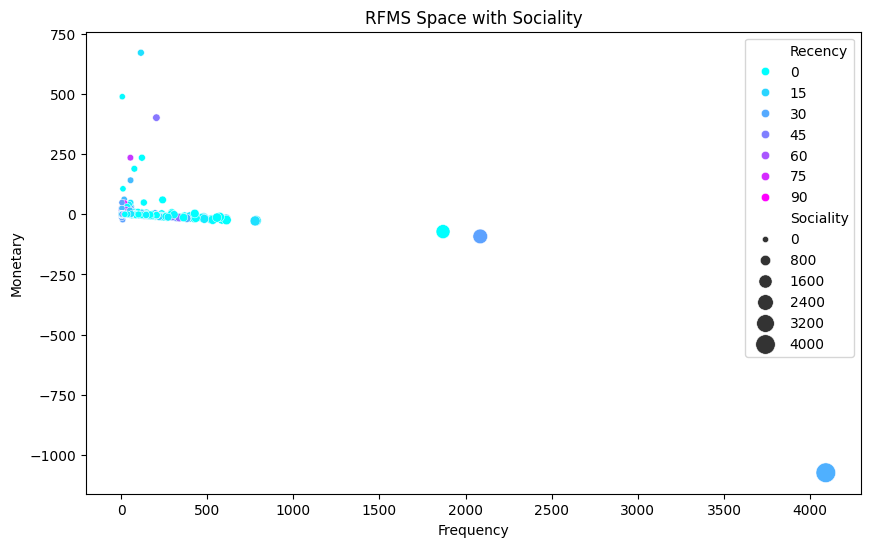

In [47]:
# Scatter plot for Monetary vs Frequency, sized by Sociality and colored by Recency
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfms,
    x='Frequency',
    y='Monetary',
    hue='Recency',
    size='Sociality',
    palette='cool',
    sizes=(20, 200)
)
plt.title('RFMS Space with Sociality')
plt.show()

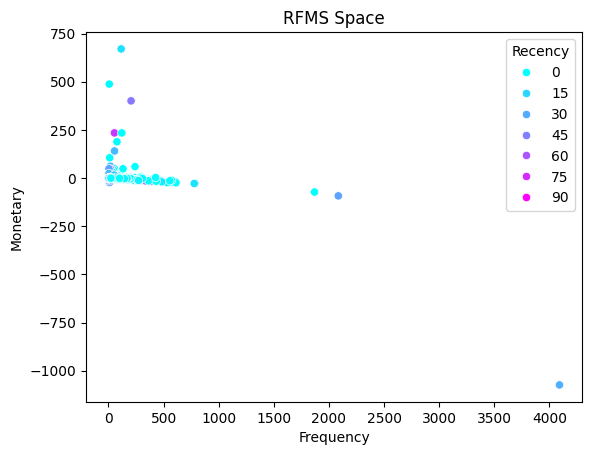

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot for Monetary vs Frequency, colored by Recency
sns.scatterplot(data=rfms, x='Frequency', y='Monetary', hue='Recency', palette='cool')
plt.title('RFMS Space')
plt.show()


In [48]:
# Calculate RFMS Score including Sociality
rfms['RFMS_Score'] = (1 / (rfms['Recency'] + 1)) + rfms['Frequency'] + rfms['Monetary'] + rfms['Sociality']

# Define a threshold based on quantiles or a fixed value
threshold = rfms['RFMS_Score'].quantile(0.75)  # Top 25% customers

# Assign Default Labels based on the threshold
rfms['Default_Label'] = rfms['RFMS_Score'].apply(lambda x: 'Good' if x > threshold else 'Bad')


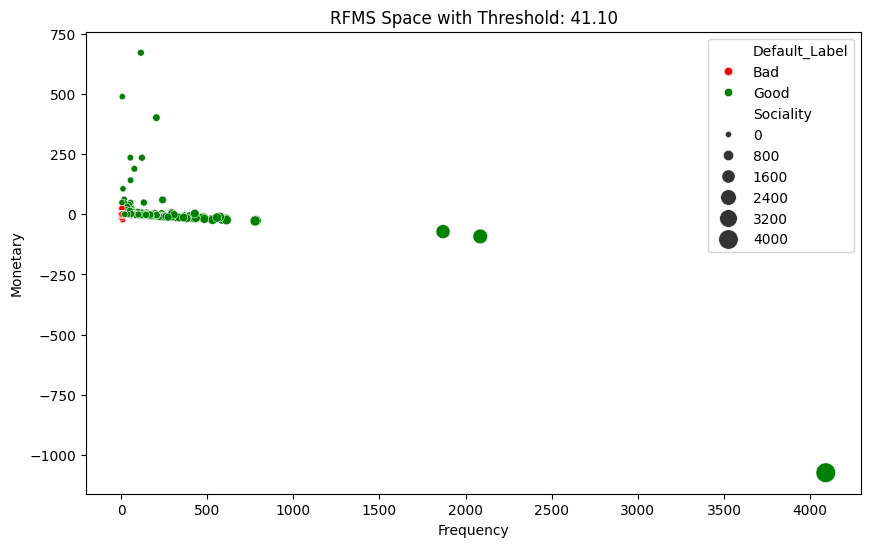

In [49]:
# Visualize RFMS space
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfms,
    x='Frequency',
    y='Monetary',
    hue='Default_Label',
    size='Sociality',
    palette={'Good': 'green', 'Bad': 'red'},
    sizes=(20, 200)
)
plt.title(f'RFMS Space with Threshold: {threshold:.2f}')
plt.show()